In [2]:
import sys
import os
import numpy as np                                # numpy is a collection of python modules for array math.
from matplotlib import pyplot as plt              # A collection of modules. Needed here to display images and graphs.
from matplotlib import pylab                      # A collection of modules. Needed here to plot histograms.
sys.path.append('/Users/benkoch/Desktop/UChicago/2nd year/Spring/ASTR 21200/a212pylibs') # Adds the path to the DataPype module to the system path.
from datapype.datafits import DataFits            # Gets the function that makes datapype io objects from module datafits in package datapype.
from astropy.io import fits                       # Need this if you want to use astropy.io io objects.
from ipywidgets import interact                   # Need this for interactive plots.
from matplotlib.colors import LogNorm             # Machinery for LogNorm scaling of intensities.
from matplotlib.colors import SymLogNorm          # Machinery for SymLogNorm scaling of intensities.
from matplotlib.colors import PowerNorm           # Machinery for LogNorm (e.g., square root) scaling of intensities.
from astropy.stats import mad_std                 # The median absolute deviation, a more robust estimator than std.
import scipy.ndimage as nd                        # Various algorithms for image transformations.


# ## Use this if dah_functions is a subdirectory of a212pylibs.
# from dah_functions.dah_functions import head
# from dah_functions.dah_functions import displaypic
# from dah_functions.dah_functions import displaypic2
# from dah_functions.dah_functions import show_image
# from dah_functions.dah_functions import blink_images
# from dah_functions.dah_functions import blink2images
# from dah_functions.dah_functions import rowplot
# from dah_functions.dah_functions import colplot
# from dah_functions.dah_functions import rowcolplot

## Use this if dah_functions is stored in a different path from a212pylibs.
## The following adds a bunch of functions in a module stored in the path below.
sys.path.append('/Users/benkoch/Desktop/UChicago/2nd year/Spring/ASTR 21200/a212pylibs/dah_functions') # Adds path to MyCode directory on my computer to system python path.
from dah_functions_2 import head
from dah_functions_2 import displaypic
from dah_functions_2 import displaypic2
from dah_functions_2 import show_image
from dah_functions_2 import blink_images
from dah_functions_2 import rowplot
from dah_functions_2 import colplot
from dah_functions_2 import rowcolplot
from dah_functions_2 import moments
from dah_functions_2 import quickpic
from dah_functions_2 import getpatch
from dah_functions_2 import stackfits

###############################################################################
# ## Don't need the following in this notebook. Hold on to them for now.
# import time        
# import re
# import scipy.stats
# import matplotlib.colors as colors
# import configobj  #What is this? Where does it come from?
###############################################################################

In [3]:
len(get_ipython().user_ns.keys())

49

In [4]:
datapath = '/Users/benkoch/Desktop/UChicago/2nd year/Spring/ASTR 21200/24inch_data/190526/dark'
median_path = '/Users/benkoch/Desktop/UChicago/2nd year/Spring/ASTR 21200/24inch_data/190526/dark/mdark'
filter_path = '/Users/benkoch/Desktop/UChicago/2nd year/Spring/ASTR 21200/24inch_data/190526/dark/mdark/mfdark'

Apply the median filter to the images

In [ ]:
whichpath = datapath

## For ALL the files in the directory.
allfiles = [f for f in os.listdir(datapath)]

allfiles = sorted(allfiles)       ## This is necessary on my Mac, may not be for others?
for i in range(len(allfiles)):
    print( i, allfiles[i])

20 second exposure

In [ ]:
#make a stack of 20s images to be median filtered

whichpath = datapath

somefiles = [f for f in os.listdir(whichpath) if '.fit' in f and '_bias' not in f and 'mdark' not in f
            and "_020s" in f]

somefiles = sorted(somefiles)       ## This is necessary on my Mac, may not be for others?
for i in range(len(somefiles)):
    print( i, somefiles[i])

In [ ]:
acceptlist = True             # True if you want to accept all the files in somefiles.
contiguous = True             # True if you want to accept a contiguous subset of somefiles.
startfile, endfile = 5,9      # The first and last files in a contiquous subset.
flist = [0,3,4,5,6,7,8]        # An explicit list of the files you want to accept.

if acceptlist == True:
    files = somefiles
    for i in range(len(files)):
        print(i, files[i])
else:
    if contiguous == True:
        files = somefiles[startfile:endfile+1]
        for i in range(len(files)):
            print( i, files[i])
    else:
        files = []
        for i in range(len(flist)):
            files.append(somefiles[flist[i]])
        for i in range(len(files)):
            print( i, flist[i], files[i])

In [ ]:
## Make a stack of images.
image, headlist, rows, cols, imedian, imad = stackfits(datapath,files)

In [ ]:
twentystack = image
filtered_twenty = nd.median_filter(twentystack, (5,1,1))

In [ ]:
# Make a median dark image from the image stack
dark = np.nanmedian(filtered_twenty, axis=0)
darkmed = np.nanmedian(dark)
darkstd = np.nanstd(dark)
darkmadstd = mad_std(dark,ignore_nan=True)

# Calculate the median and std of the median dark image constructed above.
# Exclude very large values from the calculation of the std (those greater than 2 times the median).
darkproxy = dark.copy()
darkmask = np.where(dark > darkmed * 2.0) # Criterion for eliminating very large pixel values from the std calculation.
darkproxy[darkmask] = np.nan
darkproxymed = np.nanmedian(darkproxy)
darkproxystd = np.nanstd(darkproxy)
darkproxymadstd = mad_std(darkproxy,ignore_nan=True)
print(darkmed, darkstd, darkmadstd)
print(darkproxymed, darkproxystd, darkproxymadstd)

In [ ]:
## Create a list of all the dark files from which the median dark file was constructed.

filestring = ''
for i in range(len(files)):
    if i == 0:
        filestring = filestring + files[i]
    else:
        filestring = filestring + ', ' + files[i] 
print(filestring)

In [ ]:
## Select an output directory and construct a name for the output file.
## Check whether the name and output path are correct before going on to the next cell.

outfolder = os.path.join(median_path,'mfdark')           # Directory in which to save the file.
whichfile = 0                   # Index of input file which will provide a basename and baseheader.
basename = files[whichfile]

print('basename =',basename)
newfilename = '' + basename[4:14] + basename[-9:] + 's'
print('newfilename =', newfilename)
print('outfolder =',outfolder)

baseheader = headlist[whichfile].copy()   # Create a copy of the output header (so you won't overwrite the headlist).
baseheader

In [ ]:
'''Prepare to save an image using DataFits().
If desired, also add a header from a template and make changes and/or additions to it.
Note that if the datatype of raw dark files is uint16, you need to change the value of
BZERO in the header from 32768 to 0.0, since the data in the output file will be written
as 64-bit floating point, and you do not want the offset.'''

## Provide a note for the 'notes' keyword data field of the fits header.
notestring = 'This file was created on 20190411 by Al Harper.'

## Input data for this cell:
outimage = dark                         # The image to save.
outname = newfilename                   # The file name for the output image.
outf = os.path.join(outfolder,outname)  # Full name of file including path.

##################################################################################################
# ## To save with DataFits io object.
# outd = DataFits()                       # Make a DataFits object to accept the output data.
# outd.imageset(outimage)                 # Load image data into the primary HDU.
##################################################################################################
## To save with astropy.io io object.
outd = fits.PrimaryHDU()                # Construct fits PrimaryHDU object to accept the output data.
outd.data = outimage                    # Load image data.
##################################################################################################

## Use the following if you want to adopt the header from one of the input files.
outd.header = baseheader                # Set the output header.


# # Use something like the following if you want to add any keywords and values to the fits header:
outd.header['filetype'] = 'masterdark'
# outd.header['flipstat'] = 'Port=1'        # FLIPSTAT is the port number of the Optec Perseus port selector mirror.
# outd.header['shutter'] = 'open'           # SHUTTER is the status of the dome shutter (slit) 'open' or 'closed'.
# outd.header['slaved'] = 'True'            # SLAVED is whether the dome azimuth is commanded to the telescope azimuth.
outd.header['notes'] = notestring
outd.header['filelist'] = filestring
outd.header['object'] = 'dark exposure'
outd.header['telescop'] = 'Yerkes 24-inch'
outd.header['basenam'] = basename
outd.header['bzero'] = 0.0
print('output file =', outf)
outd.header

In [ ]:
## Now save the file (or not).
use_datafits = False                              # Set use_datafits = True for DataFits io. False for astropy.io.
print(outf)
yes_or_no = input('Save file? Enter "y" or "n":')
if yes_or_no == 'y':                              # Write the fits file. Overwrite existing file with same name.
    if use_datafits == True:
        outd.save(outf)                           # Use with DataFits object. Will overwrite.
    else:
        outd.writeto(outf,overwrite = False)       # Use with astropy.io object. Can choose to overwrite or not.    
    print(outname + ' has been saved.')
else:
    print('OK-- file was not saved.')

40 second exposure

In [ ]:
#make a stack of 40s images to be median filtered

whichpath = datapath

somefiles = [f for f in os.listdir(whichpath) if '.fit' in f and '_bias' not in f and 'mdark' not in f
            and "_040s" in f]

somefiles = sorted(somefiles)       ## This is necessary on my Mac, may not be for others?
for i in range(len(somefiles)):
    print( i, somefiles[i])

In [ ]:
acceptlist = True             # True if you want to accept all the files in somefiles.
contiguous = True             # True if you want to accept a contiguous subset of somefiles.
startfile, endfile = 5,9      # The first and last files in a contiquous subset.
flist = [0,3,4,5,6,7,8]        # An explicit list of the files you want to accept.

if acceptlist == True:
    files = somefiles
    for i in range(len(files)):
        print(i, files[i])
else:
    if contiguous == True:
        files = somefiles[startfile:endfile+1]
        for i in range(len(files)):
            print( i, files[i])
    else:
        files = []
        for i in range(len(flist)):
            files.append(somefiles[flist[i]])
        for i in range(len(files)):
            print( i, flist[i], files[i])

In [ ]:
## Make a stack of images.
image, headlist, rows, cols, imedian, imad = stackfits(datapath,files)

In [ ]:
fortystack = image
filtered_forty = nd.median_filter(fortystack, (5,1,1))

In [ ]:
# Make a median dark image from the image stack
dark = np.nanmedian(filtered_forty, axis=0)
darkmed = np.nanmedian(dark)
darkstd = np.nanstd(dark)
darkmadstd = mad_std(dark,ignore_nan=True)

# Calculate the median and std of the median dark image constructed above.
# Exclude very large values from the calculation of the std (those greater than 2 times the median).
darkproxy = dark.copy()
darkmask = np.where(dark > darkmed * 2.0) # Criterion for eliminating very large pixel values from the std calculation.
darkproxy[darkmask] = np.nan
darkproxymed = np.nanmedian(darkproxy)
darkproxystd = np.nanstd(darkproxy)
darkproxymadstd = mad_std(darkproxy,ignore_nan=True)
print(darkmed, darkstd, darkmadstd)
print(darkproxymed, darkproxystd, darkproxymadstd)

In [ ]:
## Create a list of all the dark files from which the median dark file was constructed.

filestring = ''
for i in range(len(files)):
    if i == 0:
        filestring = filestring + files[i]
    else:
        filestring = filestring + ', ' + files[i] 
print(filestring)

In [ ]:
## Select an output directory and construct a name for the output file.
## Check whether the name and output path are correct before going on to the next cell.

outfolder = os.path.join(median_path,'mfdark')           # Directory in which to save the file.
whichfile = 0                   # Index of input file which will provide a basename and baseheader.
basename = files[whichfile]

print('basename =',basename)
newfilename = '' + basename[4:14] + basename[-9:] + 's'
print('newfilename =', newfilename)
print('outfolder =',outfolder)

baseheader = headlist[whichfile].copy()   # Create a copy of the output header (so you won't overwrite the headlist).
baseheader

In [ ]:
'''Prepare to save an image using DataFits().
If desired, also add a header from a template and make changes and/or additions to it.
Note that if the datatype of raw dark files is uint16, you need to change the value of
BZERO in the header from 32768 to 0.0, since the data in the output file will be written
as 64-bit floating point, and you do not want the offset.'''

## Provide a note for the 'notes' keyword data field of the fits header.
notestring = 'This file was created on 20190411 by Al Harper.'

## Input data for this cell:
outimage = dark                         # The image to save.
outname = newfilename                   # The file name for the output image.
outf = os.path.join(outfolder,outname)  # Full name of file including path.

##################################################################################################
# ## To save with DataFits io object.
# outd = DataFits()                       # Make a DataFits object to accept the output data.
# outd.imageset(outimage)                 # Load image data into the primary HDU.
##################################################################################################
## To save with astropy.io io object.
outd = fits.PrimaryHDU()                # Construct fits PrimaryHDU object to accept the output data.
outd.data = outimage                    # Load image data.
##################################################################################################

## Use the following if you want to adopt the header from one of the input files.
outd.header = baseheader                # Set the output header.


# # Use something like the following if you want to add any keywords and values to the fits header:
outd.header['filetype'] = 'masterdark'
# outd.header['flipstat'] = 'Port=1'        # FLIPSTAT is the port number of the Optec Perseus port selector mirror.
# outd.header['shutter'] = 'open'           # SHUTTER is the status of the dome shutter (slit) 'open' or 'closed'.
# outd.header['slaved'] = 'True'            # SLAVED is whether the dome azimuth is commanded to the telescope azimuth.
outd.header['notes'] = notestring
outd.header['filelist'] = filestring
outd.header['object'] = 'dark exposure'
outd.header['telescop'] = 'Yerkes 24-inch'
outd.header['basenam'] = basename
outd.header['bzero'] = 0.0
print('output file =', outf)
outd.header

In [ ]:
## Now save the file (or not).
use_datafits = False                              # Set use_datafits = True for DataFits io. False for astropy.io.
print(outf)
yes_or_no = input('Save file? Enter "y" or "n":')
if yes_or_no == 'y':                              # Write the fits file. Overwrite existing file with same name.
    if use_datafits == True:
        outd.save(outf)                           # Use with DataFits object. Will overwrite.
    else:
        outd.writeto(outf,overwrite = False)       # Use with astropy.io object. Can choose to overwrite or not.    
    print(outname + ' has been saved.')
else:
    print('OK-- file was not saved.')

100 second exposure

In [ ]:
#make a stack of 100s images to be median filtered

whichpath = datapath

somefiles = [f for f in os.listdir(whichpath) if '.fit' in f and '_bias' not in f and 'mdark' not in f
            and "_100s" in f]

somefiles = sorted(somefiles)       ## This is necessary on my Mac, may not be for others?
for i in range(len(somefiles)):
    print( i, somefiles[i])

In [ ]:
acceptlist = True             # True if you want to accept all the files in somefiles.
contiguous = True             # True if you want to accept a contiguous subset of somefiles.
startfile, endfile = 5,9      # The first and last files in a contiquous subset.
flist = [0,3,4,5,6,7,8]        # An explicit list of the files you want to accept.

if acceptlist == True:
    files = somefiles
    for i in range(len(files)):
        print(i, files[i])
else:
    if contiguous == True:
        files = somefiles[startfile:endfile+1]
        for i in range(len(files)):
            print( i, files[i])
    else:
        files = []
        for i in range(len(flist)):
            files.append(somefiles[flist[i]])
        for i in range(len(files)):
            print( i, flist[i], files[i])

In [ ]:
## Make a stack of images.
image, headlist, rows, cols, imedian, imad = stackfits(datapath,files)

In [ ]:
hundredstack = image
filtered_hundred = nd.median_filter(hundredstack, (5,1,1))

In [ ]:
# Make a median dark image from the image stack
dark = np.nanmedian(filtered_hundred, axis=0)
darkmed = np.nanmedian(dark)
darkstd = np.nanstd(dark)
darkmadstd = mad_std(dark,ignore_nan=True)

# Calculate the median and std of the median dark image constructed above.
# Exclude very large values from the calculation of the std (those greater than 2 times the median).
darkproxy = dark.copy()
darkmask = np.where(dark > darkmed * 2.0) # Criterion for eliminating very large pixel values from the std calculation.
darkproxy[darkmask] = np.nan
darkproxymed = np.nanmedian(darkproxy)
darkproxystd = np.nanstd(darkproxy)
darkproxymadstd = mad_std(darkproxy,ignore_nan=True)
print(darkmed, darkstd, darkmadstd)
print(darkproxymed, darkproxystd, darkproxymadstd)

In [ ]:
## Create a list of all the dark files from which the median dark file was constructed.

filestring = ''
for i in range(len(files)):
    if i == 0:
        filestring = filestring + files[i]
    else:
        filestring = filestring + ', ' + files[i] 
print(filestring)

In [ ]:
## Select an output directory and construct a name for the output file.
## Check whether the name and output path are correct before going on to the next cell.

outfolder = os.path.join(median_path,'mfdark')           # Directory in which to save the file.
whichfile = 0                   # Index of input file which will provide a basename and baseheader.
basename = files[whichfile]

print('basename =',basename)
newfilename = '' + basename[4:14] + basename[-9:] + 's'
print('newfilename =', newfilename)
print('outfolder =',outfolder)

baseheader = headlist[whichfile].copy()   # Create a copy of the output header (so you won't overwrite the headlist).
baseheader

In [ ]:
'''Prepare to save an image using DataFits().
If desired, also add a header from a template and make changes and/or additions to it.
Note that if the datatype of raw dark files is uint16, you need to change the value of
BZERO in the header from 32768 to 0.0, since the data in the output file will be written
as 64-bit floating point, and you do not want the offset.'''

## Provide a note for the 'notes' keyword data field of the fits header.
notestring = 'This file was created on 20190411 by Al Harper.'

## Input data for this cell:
outimage = dark                         # The image to save.
outname = newfilename                   # The file name for the output image.
outf = os.path.join(outfolder,outname)  # Full name of file including path.

##################################################################################################
# ## To save with DataFits io object.
# outd = DataFits()                       # Make a DataFits object to accept the output data.
# outd.imageset(outimage)                 # Load image data into the primary HDU.
##################################################################################################
## To save with astropy.io io object.
outd = fits.PrimaryHDU()                # Construct fits PrimaryHDU object to accept the output data.
outd.data = outimage                    # Load image data.
##################################################################################################

## Use the following if you want to adopt the header from one of the input files.
outd.header = baseheader                # Set the output header.


# # Use something like the following if you want to add any keywords and values to the fits header:
outd.header['filetype'] = 'masterdark'
# outd.header['flipstat'] = 'Port=1'        # FLIPSTAT is the port number of the Optec Perseus port selector mirror.
# outd.header['shutter'] = 'open'           # SHUTTER is the status of the dome shutter (slit) 'open' or 'closed'.
# outd.header['slaved'] = 'True'            # SLAVED is whether the dome azimuth is commanded to the telescope azimuth.
outd.header['notes'] = notestring
outd.header['filelist'] = filestring
outd.header['object'] = 'dark exposure'
outd.header['telescop'] = 'Yerkes 24-inch'
outd.header['basenam'] = basename
outd.header['bzero'] = 0.0
print('output file =', outf)
outd.header

In [ ]:
## Now save the file (or not).
use_datafits = False                              # Set use_datafits = True for DataFits io. False for astropy.io.
print(outf)
yes_or_no = input('Save file? Enter "y" or "n":')
if yes_or_no == 'y':                              # Write the fits file. Overwrite existing file with same name.
    if use_datafits == True:
        outd.save(outf)                           # Use with DataFits object. Will overwrite.
    else:
        outd.writeto(outf,overwrite = False)       # Use with astropy.io object. Can choose to overwrite or not.    
    print(outname + ' has been saved.')
else:
    print('OK-- file was not saved.')

180 second exposure

In [ ]:
#make a stack of 180s images to be median filtered

whichpath = datapath

somefiles = [f for f in os.listdir(whichpath) if '.fit' in f and '_bias' not in f and 'mdark' not in f
            and "_180s" in f]

somefiles = sorted(somefiles)       ## This is necessary on my Mac, may not be for others?
for i in range(len(somefiles)):
    print( i, somefiles[i])

In [ ]:
acceptlist = True             # True if you want to accept all the files in somefiles.
contiguous = True             # True if you want to accept a contiguous subset of somefiles.
startfile, endfile = 5,9      # The first and last files in a contiquous subset.
flist = [0,3,4,5,6,7,8]        # An explicit list of the files you want to accept.

if acceptlist == True:
    files = somefiles
    for i in range(len(files)):
        print(i, files[i])
else:
    if contiguous == True:
        files = somefiles[startfile:endfile+1]
        for i in range(len(files)):
            print( i, files[i])
    else:
        files = []
        for i in range(len(flist)):
            files.append(somefiles[flist[i]])
        for i in range(len(files)):
            print( i, flist[i], files[i])

In [ ]:
## Make a stack of images.
image, headlist, rows, cols, imedian, imad = stackfits(datapath,files)

In [ ]:
oneeightystack = image
filtered_oneeighty = nd.median_filter(oneeightystack, (5,1,1))

In [ ]:
# Make a median dark image from the image stack
dark = np.nanmedian(filtered_oneeighty, axis=0)
darkmed = np.nanmedian(dark)
darkstd = np.nanstd(dark)
darkmadstd = mad_std(dark,ignore_nan=True)

# Calculate the median and std of the median dark image constructed above.
# Exclude very large values from the calculation of the std (those greater than 2 times the median).
darkproxy = dark.copy()
darkmask = np.where(dark > darkmed * 2.0) # Criterion for eliminating very large pixel values from the std calculation.
darkproxy[darkmask] = np.nan
darkproxymed = np.nanmedian(darkproxy)
darkproxystd = np.nanstd(darkproxy)
darkproxymadstd = mad_std(darkproxy,ignore_nan=True)
print(darkmed, darkstd, darkmadstd)
print(darkproxymed, darkproxystd, darkproxymadstd)

In [ ]:
## Create a list of all the dark files from which the median dark file was constructed.

filestring = ''
for i in range(len(files)):
    if i == 0:
        filestring = filestring + files[i]
    else:
        filestring = filestring + ', ' + files[i] 
print(filestring)

In [ ]:
## Select an output directory and construct a name for the output file.
## Check whether the name and output path are correct before going on to the next cell.

outfolder = os.path.join(median_path,'mfdark')           # Directory in which to save the file.
whichfile = 0                   # Index of input file which will provide a basename and baseheader.
basename = files[whichfile]

print('basename =',basename)
newfilename = '' + basename[4:14] + basename[-9:] + 's'
print('newfilename =', newfilename)
print('outfolder =',outfolder)

baseheader = headlist[whichfile].copy()   # Create a copy of the output header (so you won't overwrite the headlist).
baseheader

In [ ]:
'''Prepare to save an image using DataFits().
If desired, also add a header from a template and make changes and/or additions to it.
Note that if the datatype of raw dark files is uint16, you need to change the value of
BZERO in the header from 32768 to 0.0, since the data in the output file will be written
as 64-bit floating point, and you do not want the offset.'''

## Provide a note for the 'notes' keyword data field of the fits header.
notestring = 'This file was created on 20190411 by Al Harper.'

## Input data for this cell:
outimage = dark                         # The image to save.
outname = newfilename                   # The file name for the output image.
outf = os.path.join(outfolder,outname)  # Full name of file including path.

##################################################################################################
# ## To save with DataFits io object.
# outd = DataFits()                       # Make a DataFits object to accept the output data.
# outd.imageset(outimage)                 # Load image data into the primary HDU.
##################################################################################################
## To save with astropy.io io object.
outd = fits.PrimaryHDU()                # Construct fits PrimaryHDU object to accept the output data.
outd.data = outimage                    # Load image data.
##################################################################################################

## Use the following if you want to adopt the header from one of the input files.
outd.header = baseheader                # Set the output header.


# # Use something like the following if you want to add any keywords and values to the fits header:
outd.header['filetype'] = 'masterdark'
# outd.header['flipstat'] = 'Port=1'        # FLIPSTAT is the port number of the Optec Perseus port selector mirror.
# outd.header['shutter'] = 'open'           # SHUTTER is the status of the dome shutter (slit) 'open' or 'closed'.
# outd.header['slaved'] = 'True'            # SLAVED is whether the dome azimuth is commanded to the telescope azimuth.
outd.header['notes'] = notestring
outd.header['filelist'] = filestring
outd.header['object'] = 'dark exposure'
outd.header['telescop'] = 'Yerkes 24-inch'
outd.header['basenam'] = basename
outd.header['bzero'] = 0.0
print('output file =', outf)
outd.header

In [ ]:
## Now save the file (or not).
use_datafits = False                              # Set use_datafits = True for DataFits io. False for astropy.io.
print(outf)
yes_or_no = input('Save file? Enter "y" or "n":')
if yes_or_no == 'y':                              # Write the fits file. Overwrite existing file with same name.
    if use_datafits == True:
        outd.save(outf)                           # Use with DataFits object. Will overwrite.
    else:
        outd.writeto(outf,overwrite = False)       # Use with astropy.io object. Can choose to overwrite or not.    
    print(outname + ' has been saved.')
else:
    print('OK-- file was not saved.')

This part gives correlation coefficients for the filtered medians

In [5]:
whichpath3 = filter_path

## For ALL the files in the directory.
allfiles = [f for f in os.listdir(filter_path)]

allfiles = sorted(allfiles)       ## This is necessary on my Mac, may not be for others?
for i in range(len(allfiles)):
    print( i, allfiles[i])

0 .DS_Store
1 _190526_AA_020s.fits
2 _190526_AA_040s.fits
3 _190526_AA_100s.fits
4 _190526_AA_180s.fits


In [6]:
whichpath3 = filter_path

somefiles = [f for f in os.listdir(whichpath3) if '.fit' in f]

somefiles = sorted(somefiles)       ## This is necessary on my Mac, may not be for others?
for i in range(len(somefiles)):
    print( i, somefiles[i])

0 _190526_AA_020s.fits
1 _190526_AA_040s.fits
2 _190526_AA_100s.fits
3 _190526_AA_180s.fits


In [7]:
acceptlist = True             # True if you want to accept all the files in somefiles.
contiguous = True             # True if you want to accept a contiguous subset of somefiles.
startfile, endfile = 5,9      # The first and last files in a contiquous subset.
flist = [0,3,4,5,6,7,8]        # An explicit list of the files you want to accept.

if acceptlist == True:
    files = somefiles
    for i in range(len(files)):
        print(i, files[i])
else:
    if contiguous == True:
        files = allfiles[startfile:endfile+1]
        for i in range(len(files)):
            print( i, files[i])
    else:
        files = []
        for i in range(len(flist)):
            files.append(allfiles[flist[i]])
        for i in range(len(files)):
            print( i, flist[i], files[i])

0 _190526_AA_020s.fits
1 _190526_AA_040s.fits
2 _190526_AA_100s.fits
3 _190526_AA_180s.fits


In [8]:
## Make a stack of images.
image, headlist, rows, cols, imedian, imad = stackfits(filter_path,files)

GetHeadVal: Missing Configuration
GetHeadVal: Missing Configuration
GetHeadVal: Missing Configuration
GetHeadVal: Missing Configuration


rows = 1024    cols = 1024
image.shape = (4, 1024, 1024)

0 _190526_AA_020s.fits


GetHeadVal: Missing Configuration
GetHeadVal: Missing Configuration
GetHeadVal: Missing Configuration
GetHeadVal: Missing Configuration



1 _190526_AA_040s.fits

2 _190526_AA_100s.fits

3 _190526_AA_180s.fits


In [9]:
import scipy.stats

exptime = np.zeros(len(headlist))
for i in range(len(headlist)):
    head = headlist[i]
    exptime[i] = head['EXPOSURE']
    
#plt.plot(exptime)

pixel_dark_value = image[:,1000,1000]

#plt.plot(exptime, pixel, 'k.')

corrs = np.zeros((1024,1024))
for i in range(1024):
    for j in range(1024):
        corrs[i,j] = scipy.stats.pearsonr(exptime, image[:,i,j])[0]
    
print(corrs)

/Users/benkoch/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


[[0.9848809  0.99712357 0.99993326 ... 0.99111258 0.98373875 0.96986863]
 [0.99859914 0.99414898 0.96986863 ... 0.86881454 0.91364077 0.99617783]
 [0.99914653 0.99615062 0.94735232 ... 0.99615062 0.98974691 0.96621759]
 ...
 [0.97385168 0.93067522 0.99930636 ... 0.98240524 0.99907792 0.96621759]
 [0.8885383  0.99986182 0.96982332 ... 0.84762909 0.99293693 0.98747922]
 [0.91440091 0.90983992 0.99341737 ... 0.94450099 0.98747922 0.97546862]]


In [10]:
print(scipy.stats.pearsonr(exptime, image[:,1023,0]))

(0.9144009144013716, 0.0855990855986284)


/Users/benkoch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


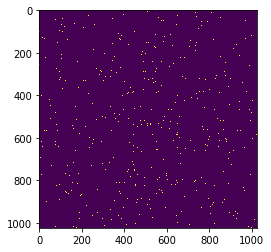

In [16]:
badpix = corrs < 0.75
plt.imshow(badpix)

In [15]:
locs = np.array(np.where(badpix == True))

for i in range(locs.shape[1]):
   print(locs[0,i],locs[1,i])

0 169
0 249
0 292
0 308
0 403
0 560
0 574
0 735
1 343
1 385
1 481
1 505
1 555
1 844
2 219
2 343
2 470
2 474
2 551
2 731
3 152
3 316
3 333
3 634
3 747
4 93
4 157
4 323
4 519
4 722
4 796
4 912
5 115
5 194
5 380
5 709
6 40
6 145
6 297
6 341
6 424
6 477
6 512
6 976
7 268
7 328
7 440
7 509
7 521
7 982
8 278
8 832
8 896
8 922
9 857
10 94
10 436
11 9
11 266
11 715
11 732
11 735
11 810
12 368
12 386
12 667
12 693
13 225
13 523
13 573
13 710
14 123
14 228
14 404
14 547
15 300
16 477
16 544
16 574
16 577
17 1
17 278
17 290
17 610
17 729
18 231
18 281
18 432
18 601
18 739
18 764
19 64
19 367
19 459
20 299
20 390
20 430
20 525
20 607
20 805
20 857
20 915
21 101
21 234
21 259
21 291
21 396
21 499
21 850
22 60
22 137
22 691
23 281
23 371
23 410
24 25
24 144
24 228
24 259
24 405
24 583
24 685
24 764
25 79
25 232
25 299
25 496
25 606
25 650
25 785
26 30
26 91
26 116
26 211
26 455
26 592
26 616
26 752
26 930
27 360
27 402
27 627
27 777
27 841
28 6
28 477
28 482
28 509
29 108
29 162
29 476
29 645
30 219

191 235
191 438
191 879
192 294
192 388
192 390
192 422
192 551
192 728
193 91
193 200
193 364
193 391
193 435
193 479
193 669
193 702
193 846
193 1005
194 26
194 71
194 486
194 559
194 606
195 7
195 353
195 479
195 537
195 617
196 292
196 294
196 366
196 425
196 602
196 652
196 710
196 756
196 980
197 143
197 438
197 641
197 682
197 787
197 831
197 952
198 139
198 241
198 487
198 586
198 883
198 932
199 67
199 455
199 552
199 572
199 807
199 815
200 79
200 167
200 325
200 330
200 625
200 629
200 745
200 790
201 31
201 91
201 260
201 262
201 317
201 327
201 783
201 1006
202 20
202 24
202 168
202 358
202 374
202 642
202 732
202 777
202 791
203 194
203 422
203 632
203 703
204 307
204 314
204 399
204 500
204 529
204 858
205 176
205 325
205 416
205 508
205 546
205 625
205 745
205 783
205 1012
206 9
206 107
206 218
206 336
206 444
206 489
206 593
206 632
207 4
207 118
207 300
207 408
207 521
207 552
207 796
207 999
208 32
208 493
208 550
208 587
208 721
208 819
208 888
209 105
209 458
209 4

426 672
426 720
426 932
427 18
427 231
427 267
427 283
427 358
427 470
427 619
427 734
427 768
427 790
427 919
427 932
427 1023
428 113
428 222
428 358
428 400
428 419
428 447
428 504
428 556
428 557
428 592
428 668
428 691
428 694
429 277
429 343
429 389
429 941
430 75
430 160
430 187
430 282
430 354
430 537
430 686
431 12
431 418
431 508
431 574
431 702
431 833
432 83
432 108
432 134
432 292
432 473
432 498
432 559
433 234
433 328
433 367
433 379
433 489
433 566
433 585
433 659
433 728
433 966
434 74
434 230
434 236
434 332
434 367
434 440
434 641
435 29
435 84
435 245
435 595
435 668
435 690
435 745
436 28
436 671
436 688
436 737
436 871
436 1007
437 94
437 121
437 250
437 468
437 558
437 638
437 700
437 701
437 886
437 912
438 128
438 542
438 708
438 735
439 118
439 128
439 236
439 251
439 268
439 303
439 451
439 492
439 568
439 595
439 646
439 724
439 809
439 933
440 55
440 59
440 161
440 162
440 204
440 249
440 261
440 274
440 402
440 429
440 468
440 536
440 600
440 627
440 641
4

637 37
637 147
637 413
637 447
637 594
637 619
637 667
637 683
637 940
638 181
638 211
638 255
638 305
638 316
638 481
638 738
638 811
638 975
639 5
639 139
639 248
639 542
639 623
639 629
639 671
639 706
639 817
640 156
640 206
640 208
640 333
640 360
640 385
640 455
640 469
640 652
640 694
640 861
640 900
641 16
641 50
641 91
641 149
641 217
641 369
641 604
641 666
641 714
641 737
641 742
641 751
641 780
641 843
641 929
641 1017
642 76
642 85
642 298
642 468
642 482
642 498
642 598
642 733
642 769
642 919
643 60
643 264
643 510
643 651
643 823
643 999
644 51
644 226
644 290
644 313
644 383
644 556
644 585
644 646
644 667
644 707
644 891
645 237
645 374
645 462
645 650
645 663
645 760
645 869
645 872
645 883
645 965
646 76
646 100
646 225
646 467
646 517
646 740
646 854
647 134
647 188
647 435
647 586
647 636
648 8
648 349
648 370
648 379
648 388
648 413
648 510
648 533
648 693
648 919
649 68
649 299
649 436
649 555
649 579
649 1009
650 222
650 267
650 491
650 610
650 687
650 688
650 

757 449
757 479
757 682
757 786
758 57
758 343
758 410
758 415
758 445
758 621
758 689
758 778
758 781
758 821
758 866
758 968
758 981
759 204
759 349
759 648
759 713
759 834
759 956
760 174
760 248
760 318
760 448
760 461
760 531
760 827
760 979
761 153
761 509
761 534
761 864
762 99
762 172
762 265
762 357
762 434
762 495
762 506
762 586
762 907
762 972
763 107
763 236
763 262
763 588
763 626
763 964
764 168
764 459
764 521
764 725
764 735
764 809
764 899
764 949
764 955
764 1005
765 315
765 379
765 413
765 429
765 460
765 804
765 871
766 26
766 79
766 302
766 320
766 378
766 398
766 474
766 540
766 601
766 617
766 688
766 717
766 756
766 780
767 177
767 323
767 664
767 973
768 87
768 124
768 128
768 185
768 376
768 505
768 598
768 853
768 882
768 914
769 42
769 94
769 309
769 358
769 627
769 734
769 742
769 852
769 943
770 46
770 223
770 424
770 556
770 638
770 639
770 712
770 938
770 958
771 169
771 199
771 200
771 245
771 596
771 715
771 749
771 866
771 938
771 944
772 11
772 247


876 206
876 324
876 651
876 683
876 837
876 922
876 972
877 15
877 22
877 239
877 297
877 303
877 650
877 655
877 805
877 932
878 167
878 292
878 305
878 347
878 363
878 407
878 452
878 560
878 583
878 614
878 690
878 890
878 910
878 955
879 68
879 133
879 196
879 253
879 264
879 279
879 319
879 543
879 626
879 634
879 637
879 669
879 843
879 907
879 937
880 42
880 653
880 1011
881 97
881 99
881 258
881 373
881 423
881 485
881 523
881 654
881 957
882 96
882 374
882 446
882 459
882 521
882 552
882 642
882 814
882 874
882 887
883 50
883 84
883 116
883 121
883 283
883 293
883 312
883 369
883 540
883 560
883 566
883 608
883 722
883 912
883 937
883 991
884 49
884 180
884 293
884 346
884 383
884 550
884 573
884 610
884 611
884 650
884 658
884 769
884 860
885 141
885 216
885 415
885 481
885 526
885 545
885 732
885 796
885 949
885 977
886 70
886 180
886 392
886 669
886 874
887 118
887 150
887 500
887 524
887 548
887 554
887 829
887 880
888 120
888 135
888 191
888 208
888 516
888 744
889 162
88

1023 397
1023 565
1023 916
1023 942


In [17]:
np.shape(locs)

(2, 8407)